In [1]:
import numpy as np
import os
import sys
import time
import torch
import torch.nn.functional as F

from torch import nn, FloatTensor, LongTensor, Tensor
from torchvision import transforms as T
from tqdm.notebook import tqdm
from typing import Callable, Dict, Iterable, List, Tuple

In [2]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
HDF5_DIR = '/media/dmitry/other/dfdc-crops/hdf5'
IMG_DIR = '/media/dmitry/other/dfdc-crops/webp_lossy'

In [3]:
sys.path.insert(0, './utils')

In [4]:
# src
sys.path.insert(0, os.path.join(BASE_DIR, 'vendors/Pytorch_Retinaface'))
sys.path.insert(0, SRC_DIR)

In [5]:
from dataset.hdf5 import HDF5Dataset
from dataset.images import ImagesDataset
from dataset.sample import FrameSampler, BalancedSampler

In [6]:
from visualise import show_images

In [7]:
def create_dataloader(bs: int, num_frames: int, real_fake_ratio: float, 
                      p_sparse_frames: float, chunks: Iterable[int]
                     ) -> torch.utils.data.DataLoader:
    dirs = [f'dfdc_train_part_{i}' for i in chunks]
    
    sampler = FrameSampler(num_frames, 
                           real_fake_ratio=real_fake_ratio, 
                           p_sparse=p_sparse_frames)
#     tfms = T.Compose([
#         T.ToTensor()
#     ])
    tfms = None
    ds = HDF5Dataset(HDF5_DIR, 
                     size=(num_frames, 256), 
                     sampler=sampler, 
                     transforms=tfms, 
                     sub_dirs=dirs)
    print('Num samples: {}'.format(len(ds)))
    
    batch_sampler = torch.utils.data.BatchSampler(
        BalancedSampler(ds),
        batch_size=bs, 
        drop_last=True
    )
    dl = torch.utils.data.DataLoader(ds, batch_sampler=batch_sampler)
    return dl

In [8]:
train_dl = create_dataloader(
    bs=12, 
    num_frames=10, 
    real_fake_ratio=100/30, 
    p_sparse_frames=0.75, 
    chunks=range(5,30)
)

Num samples: 61779


In [9]:
data = iter(train_dl)

In [10]:
batch = next(data)

In [11]:
# images = batch[0].permute(0,2,3,4,1).numpy()
# images = batch[0].permute(0,2,1,3,4) #.numpy()
images = batch[0].permute(0,2,4,1,3)
images.shape

torch.Size([12, 10, 3, 256, 256])

In [12]:
def diff(x: Tensor, dim: int) -> Tensor:
    mask = list(map(slice, x.shape[:dim]))
    mask0 = mask + [slice(1, x.size(dim))]
    mask1 = mask + [slice(0, -1)]
    return x[mask0] - x[mask1]


def image_grad(x: Tensor, n=1, keep_size=False) -> Tensor:
    for _ in range(n):
        x = diff(x, -1)
        x = diff(x, -2)
    if keep_size:
        pad = [(n + i) // 2 for i in [0, 1, 0, 1]]
        x = F.pad(x, tuple(pad))
    return x

In [13]:
img_g = image_grad(images, n=1, keep_size=True).permute(0,1,3,4,2).numpy()

img_g.shape

(12, 10, 256, 256, 3)

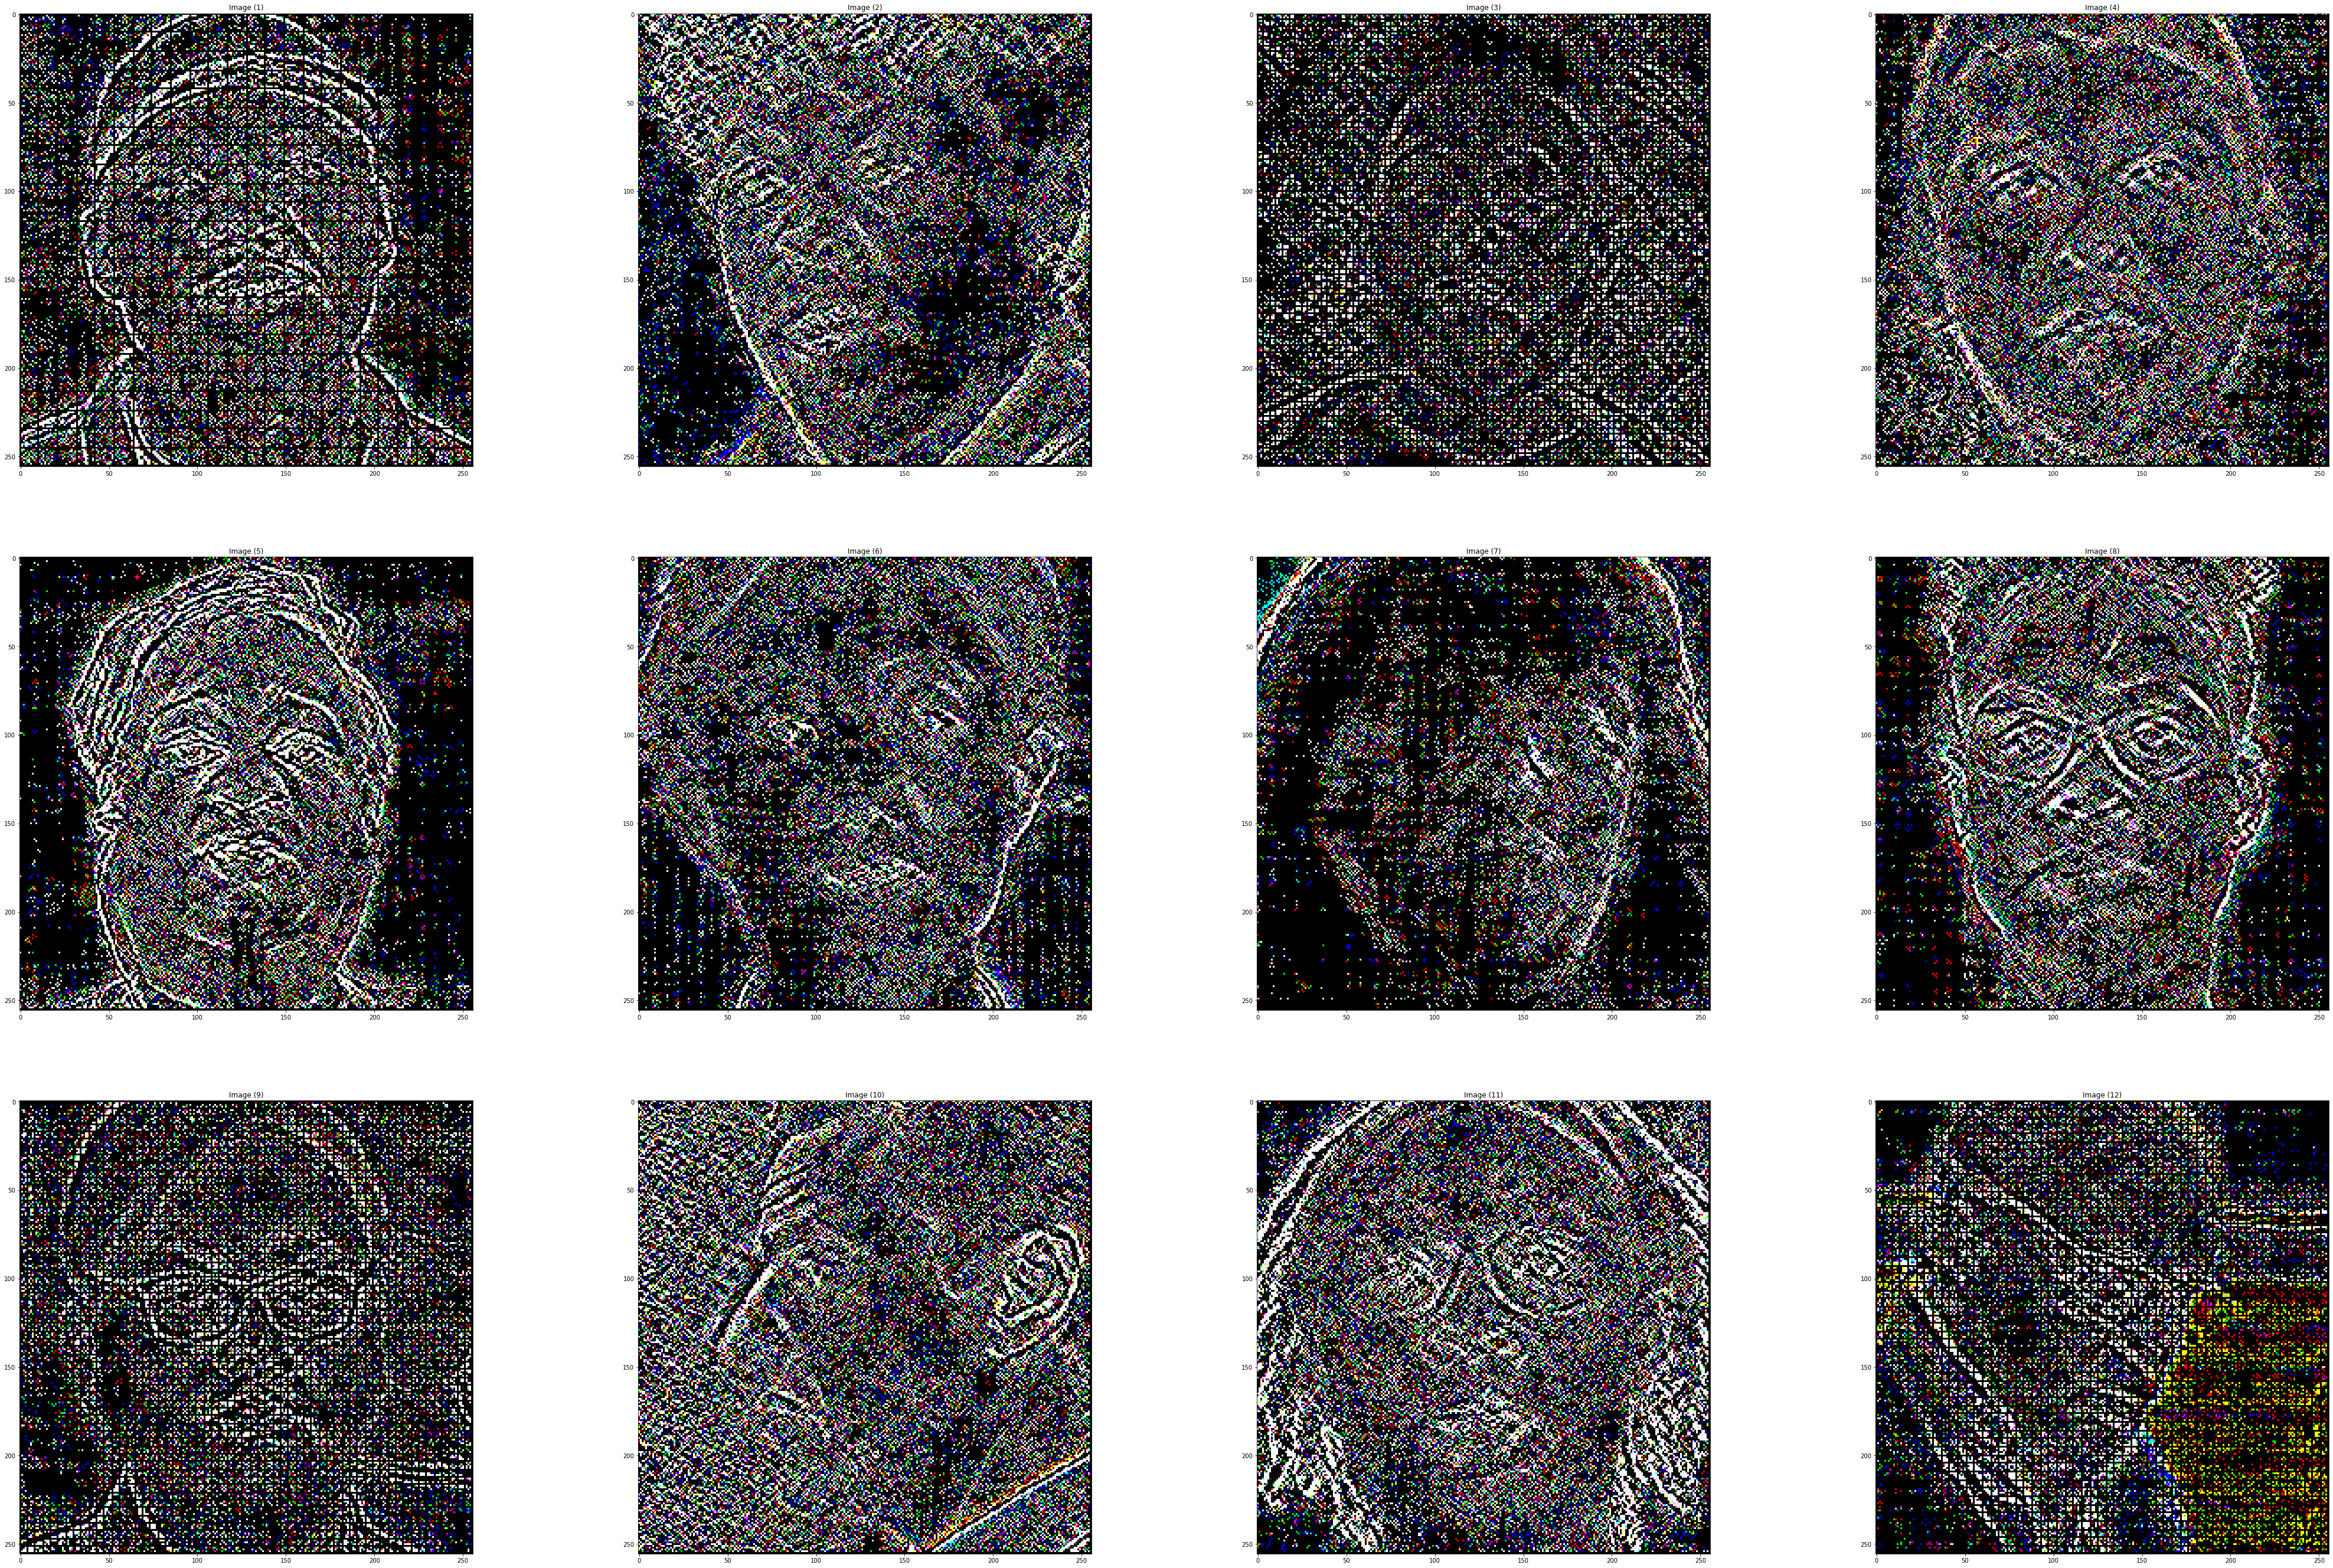

In [14]:
show_images(img_g[:,0], cols=3)

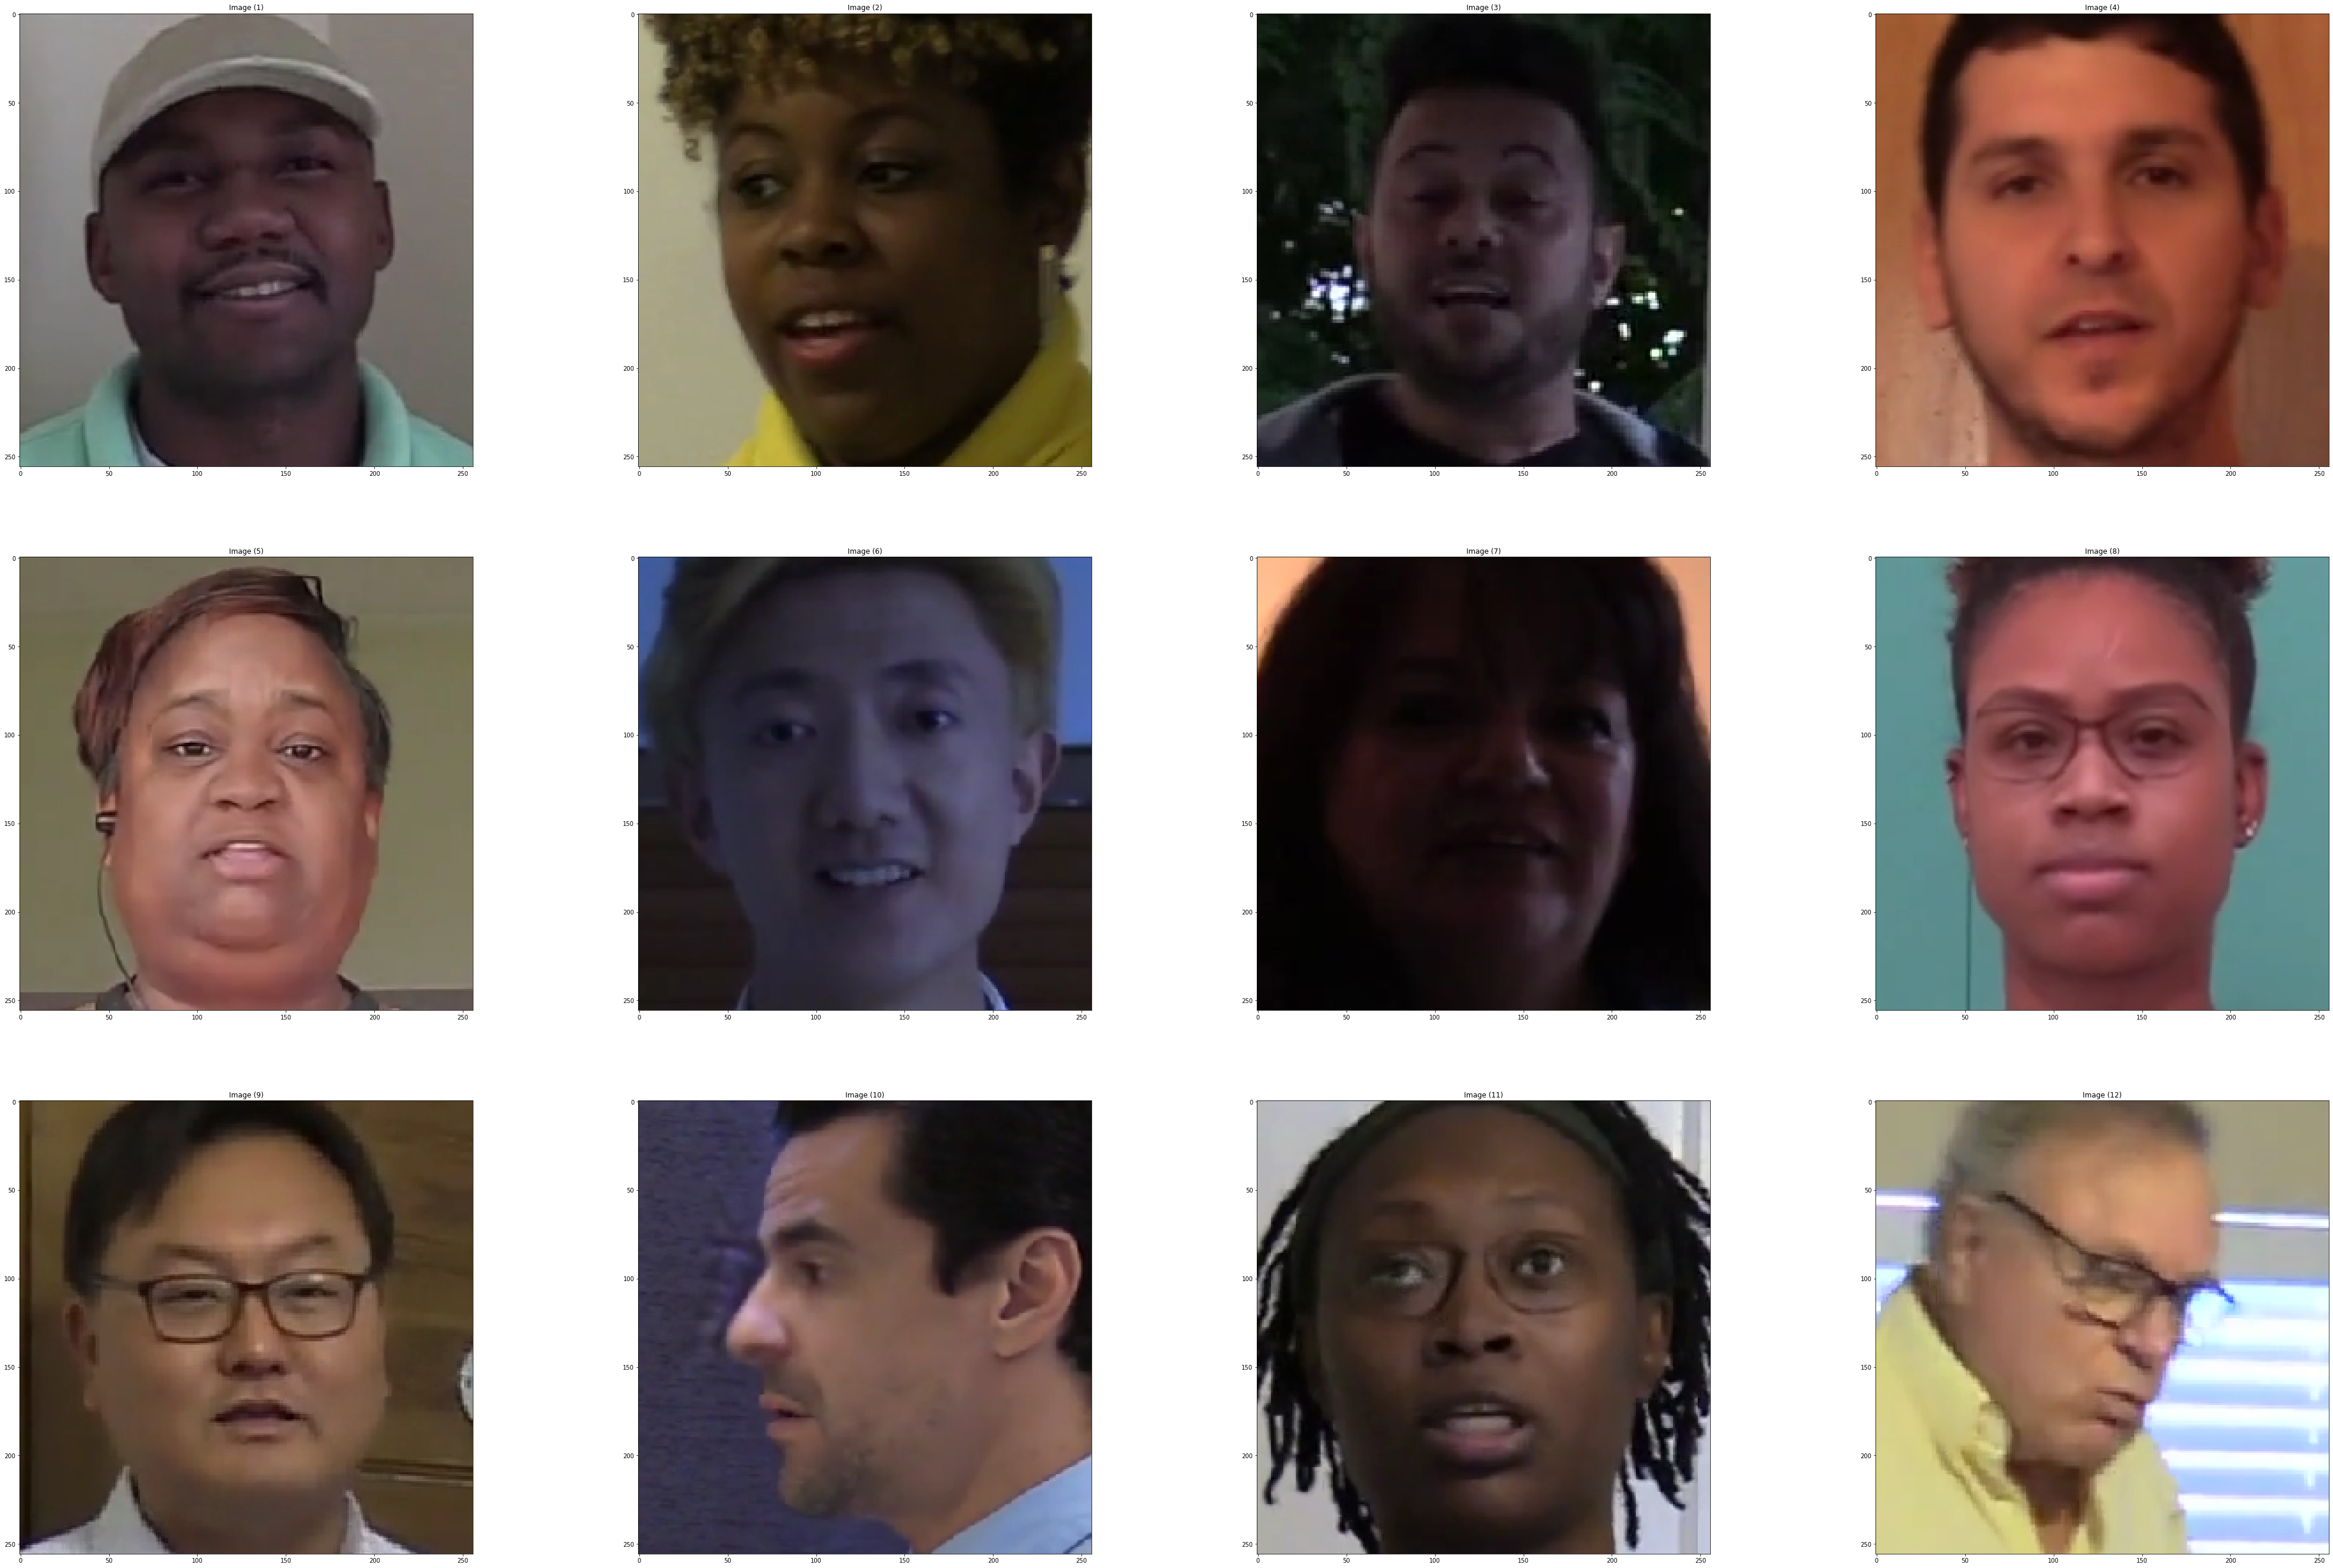

In [15]:
orig_images = batch[0].permute(0,2,1,3,4)

show_images(orig_images[:,0], cols=3)